In [1]:
import tensorflow as tf
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
from tqdm import tqdm 
from sklearn.model_selection import train_test_split

# first we need to fetch the data

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=4000)
# fetches the data as numbers -- we need to match the indexes with words

word_index = tf.keras.datasets.imdb.get_word_index()
index2word = dict((i + 3, word) for (word, i) in word_index.items())

# with the above two lines we create a dictionary that will match the indexes with their respective words

index2word[0] = '[pad]'
index2word[1] = '[bos]'
index2word[2] = '[oov]'

x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])

# after we use the dictionary to translate our data -- we have our data in english words


# the vocabulary consists of all the different words we have in our reviews -- our different features

vocabulary = list()
for text in x_train:
    tokens = text.split()
    vocabulary.extend(tokens)

vocabulary = set(vocabulary)  # it is a set since we need each word only once

# now we need to convert our data into binary vectors


x_train_binary = list()
x_test_binary = list()

for text in tqdm(x_train):
    tokens = text.split()
    binary_vector = list()
    for vocab_token in vocabulary:
        if vocab_token in tokens:
            binary_vector.append(1)
        else:
            binary_vector.append(0)
    x_train_binary.append(binary_vector)

x_train_binary = np.array(x_train_binary)

for text in tqdm(x_test):
    tokens = text.split()
    binary_vector = list()
    for vocab_token in vocabulary:
        if vocab_token in tokens:
            binary_vector.append(1)
        else:
            binary_vector.append(0)
    x_test_binary.append(binary_vector)

x_test_binary = np.array(x_test_binary)

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [03:41<00:00, 112.78it/s]


In [2]:
import math


# information gain
def IG(class_, feature):
    classes = set(class_)
    Hc = 0
    for c in classes:
        pc = list(class_).count(c) / len(class_)
        Hc += - pc * math.log(pc, 2)
    feature_values = set(feature)
    Hc_feature = 0
    for feat in feature_values:
        # pf --> P(X=x)
        pf = list(feature).count(feat) / len(feature)
        indices = [i for i in range(len(feature)) if feature[i] == feat]  # bug here
        # print(len(indices), "indices")
        classes_of_feat = [class_[i] for i in indices]  # bug here
        # print(len(classes_of_feat), "classes of feat")
        for c in classes:
            # pcf --> P(C=c|X=x)
            pcf = classes_of_feat.count(c) / len(classes_of_feat)
            if pcf != 0:
                # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                temp_H = - pf * pcf * math.log(pcf, 2)
                # sum for all values of C (class) and X (values of specific feature)
                Hc_feature += temp_H
    ig = Hc - Hc_feature
    return ig

In [3]:
class id3_node:
    def __init__(self, x, y, label=None, father=None):
        self.examples, self.results = x, y
        self.label = label

        self.father = father
        self.left_child, self.right_child = None, None

        self.depth = 0 if self.father is None else self.father.depth+1  # depth of node

        self.num_of_yes, self.num_of_no = list(y).count(1), list(y).count(0)

        self.category = 0 if self.num_of_no >= self.num_of_yes else 1

        self.percent_yes = self.num_of_yes/len(y) if len(y) > 0 else 0
        self.percent_no = self.num_of_no / len(y) if len(y) > 0 else 0

    def __str__(self):
        return str(self.label) if self.label is not None else "None"


def find_best(x, y, features_checked):  # returns the index of the best feature 
    info_gains = list()
    for i in range(len(x[0])):
        if features_checked[i]:  # -1 means already checked
            info_gains.append(-1)
            continue
        feature = [example[i] for example in x]  # the list of different features
        current_ig = IG(y, feature)
        info_gains.append(current_ig)

    best_feature = info_gains.index(max(info_gains))  # should return the index of the max info gain
    return best_feature


class id3_algorithm:
    def __init__(self):
        self.id3_root = None  # we will use the root to traverse the tree
        self.frontier = list()

    def fit(self, x, y, features_checked=None):
        if features_checked is None:
            features_checked = [False for i in range(len(x[0]))]
            self.id3_root = id3_node(x, y)  # the initial node without any splitting in teams
            self.frontier.append(self.id3_root)

        current_node = self.frontier.pop(0)  # pops the first item in the frontier

        if len(list(current_node.examples)) == 0:  # if no examples left
            return current_node.category

        if current_node.percent_yes == 1.0 or current_node.percent_no == 1.0:  # if we fully fit
            return current_node.category

        if features_checked.count(True) == len(features_checked):  # if there is not any unused feature
            return current_node.category

        best_feature = find_best(x, y, features_checked)  # we get the index of the best feature

        features_checked[best_feature] = True  # we mark this feature as used

        examples_yes = np.array([case for case in x if case[best_feature] == 1])  # value 1 in the best feature
        results_yes = np.array([y[i] for i in range(len(x)) if x[i][best_feature] == 1])

        examples_no = np.array([case for case in x if case[best_feature] == 0])  # value 0 in the best feature
        results_no = np.array([y[i] for i in range(len(x)) if x[i][best_feature] == 0])

        # we have the examples for the left and the right child
        left_child = id3_node(x=examples_yes, y=results_yes, label=best_feature, father=current_node)
        current_node.left_child = left_child

        right_child = id3_node(x=examples_no, y=results_no, label=best_feature, father=current_node)
        current_node.right_child = right_child


        # we create the two children

        self.frontier.append(left_child)
        self.frontier.append(right_child)

        self.fit(self.frontier[0].examples, self.frontier[0].results, features_checked)  

    def predict(self, x):  # returns a numpy array of the answers our decision tree will give for each
        # the idea is to traverse the tree we created and add the example in the  correct category
        # and return the array of predictions

        predictions = list()
        for case in x:
            current_node = self.id3_root
            while True:  # check if I need to change the condition  
                if current_node.left_child is not None:
                    feature_value = case[current_node.left_child.label]
                    current_node = current_node.left_child if feature_value == 1 else current_node.right_child
                else:
                    predictions.append(current_node.category)
                    break

        predictions = np.array(predictions)  # we convert the list to a numpy array
        return predictions

    def print_tree(self):
        tree = list()
        tree2 = list()
        tree.append(self.id3_root)
        tree2.append(self.id3_root)
        while len(tree) > 0:
            current_node = tree.pop(0)
            if current_node.left_child is not None:
                tree.append(current_node.left_child)
                tree2.append(current_node)

            if current_node.right_child is not None:
                tree.append(current_node.right_child)
                tree2.append(current_node)
            print(current_node)
        print(len(tree2), "tree2")

In [4]:
x_train_binary, x_dev_binary, y_train, y_dev = train_test_split(x_train_binary, y_train,  
                                                                test_size=0.3)
#we split the data into train (70% of the training data) and dev(30% of the training data)

decision_algo = id3_algorithm()
decision_algo.fit(x_train_binary, y_train)
# we train the algorithm with the training data

y_predictions = decision_algo.predict(x_test_binary)
# we evaluate with the test data

print(classification_report(y_test, y_predictions))

              precision    recall  f1-score   support

           0       0.79      0.50      0.61     12500
           1       0.63      0.86      0.73     12500

    accuracy                           0.68     25000
   macro avg       0.71      0.68      0.67     25000
weighted avg       0.71      0.68      0.67     25000



In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# custom learning curve for id3
def custom_learning_curve_id3(x_train, y_train,
                              x_val, y_val, x_test, y_test,
                              n_splits, built_in=False):
    split_size = int(len(x_train) / n_splits)
    x_splits = np.split(x_train, n_splits)  # must be equal division
    y_splits = np.split(y_train, n_splits)
    train_accuracies = list()
    val_accuracies = list()
    test_accuracies = list()
    curr_x = x_splits[0]
    print(curr_x.shape)
    curr_y = y_splits[0]
    print(curr_y.shape)

    id3 = id3_algorithm() if not built_in else DecisionTreeClassifier(criterion='entropy')
    id3.fit(curr_x, curr_y)
    train_accuracies.append(accuracy_score(curr_y,
                                           id3.predict(curr_x)))

    val_accuracies.append(accuracy_score(y_val, id3.predict(x_val)))
    test_accuracies.append(accuracy_score(y_test, id3.predict(x_test)))

    for i in range(1, len(x_splits)):
        id3 = id3_algorithm() if not built_in else DecisionTreeClassifier(criterion='entropy')
        curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
        print(curr_x.shape)
        curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)
        print(curr_y.shape)
        id3.fit(curr_x, curr_y)

        train_accuracies.append(accuracy_score(curr_y,
                                               id3.predict(curr_x)))

        val_accuracies.append(accuracy_score(y_val, id3.predict(x_val)))

        test_accuracies.append(accuracy_score(y_test, id3.predict(x_test)))

    plt.plot(list(range(split_size, len(x_train) + split_size,
                        split_size)), train_accuracies, 'o-', color="b",
             label="Training accuracy")
    plt.plot(list(range(split_size, len(x_train) + split_size,
                        split_size)), val_accuracies, 'o-', color="green",
             label="Validation accuracy")
    plt.plot(list(range(split_size, len(x_train) + split_size,
                        split_size)), test_accuracies, 'o-', color="red",
             label="Testing accuracy")
    plt.legend(loc="lower right")
    plt.show()

(3500, 3998)
(3500,)
(7000, 3998)
(7000,)
(10500, 3998)
(10500,)
(14000, 3998)
(14000,)
(17500, 3998)
(17500,)


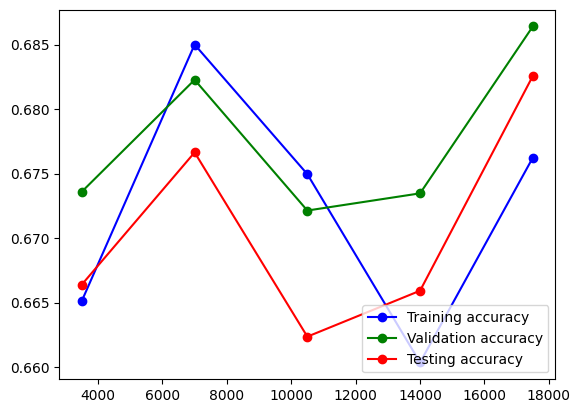

In [8]:
custom_learning_curve_id3(x_train=x_train_binary, y_train=y_train,
                           x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                           y_test=y_test, n_splits=5)
# the learning curve for id3

In [9]:
# for part b of id3 algorithm -- compare it with the sklearn algorithm "decision tree classifier"
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(x_train_binary, y_train)
dt_predictions = dt.predict(x_test_binary)

print(classification_report(y_test, dt_predictions))

              precision    recall  f1-score   support

           0       0.70      0.71      0.70     12500
           1       0.70      0.70      0.70     12500

    accuracy                           0.70     25000
   macro avg       0.70      0.70      0.70     25000
weighted avg       0.70      0.70      0.70     25000



(3500, 3998)
(3500,)
(7000, 3998)
(7000,)
(10500, 3998)
(10500,)
(14000, 3998)
(14000,)
(17500, 3998)
(17500,)


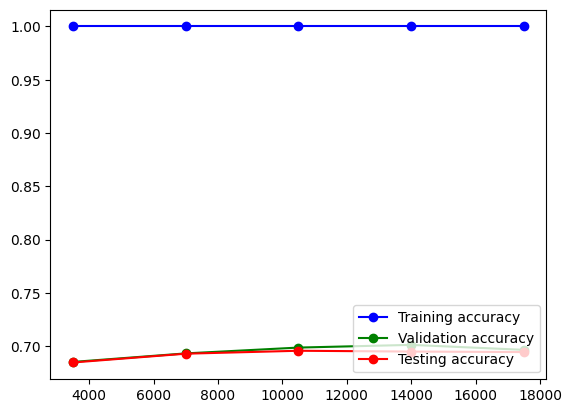

In [10]:
# the learning curve for the built in decision tree algorithm
custom_learning_curve_id3(x_train=x_train_binary, y_train=y_train,
                           x_val=x_dev_binary, y_val=y_dev, x_test=x_test_binary,
                           y_test=y_test, n_splits=5, built_in=True)
